In [39]:
import numpy as np 
import pandas as pd
import os 
import sys
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
wd = os.getcwd()
root = os.path.dirname(wd)


with open(os.path.join(root, 'data/processed/perfusion_data_cleaned.csv')) as data_file:    
    data = pd.read_csv(data_file)

# Explore Variables

In [41]:
with open(os.path.join(root, 'data/processed/variable_type_schema.json')) as data_file:    
    schema = json.load(data_file)

## Univariate Analysis

In [42]:
# get numerical variables that are output

def get_vars(col, data):
    pattern = re.compile(rf"^{re.escape(col)}_D-\d+$")
    return [
        col for col in data.columns
        if pattern.match(col)
    ]
numerical_vars = []
for col, col_info in schema.items():
    if col_info["type"] in ("float", "Int64") and col_info["role"] == "output":
        if col_info["time_dependent"] == True:
            cols = get_vars(col, data)
            numerical_vars.extend(cols)
        else:
            numerical_vars.append(col)


In [43]:
data_numerical = data[numerical_vars]
data_numerical.describe()

,VCD_D-0,VCD_D-1,VCD_D-3,VCD_D-5,VCD_D-6,VCD_D-7,VCD_D-9,VCD_D-10,Viability_D-3,Viability_D-7,...,TNF-a_D-3,TNF-a_D-7,TNF-a_D-10,IFN-y_TNF-a_D-3,IFN-y_TNF-a_D-7,IFN-y_TNF-a_D-10,CD4_CD8_ratio_D-0,CD4_CD8_ratio_D-3,CD4_CD8_ratio_D-7,CD4_CD8_ratio_D-10
count,103.000000,78.000000,9.800000e+01,9.100000e+01,8.900000e+01,1.020000e+02,1.200000e+01,8.900000e+01,87.000000,91.000000,...,14.000000,35.000000,38.000000,14.000000,33.000000,34.000000,52.000000,69.000000,69.000000,71.000000
mean,529904.935275,433366.987179,4.225976e+05,1.029744e+06,2.381107e+06,3.964716e+06,6.636693e+06,1.089432e+07,79.553548,85.437174,...,55.750000,76.057143,83.326316,19.600000,20.832121,26.761765,1.921538,2.240146,1.489436,1.238257
std,130108.366942,90934.491573,2.468808e+05,7.728004e+05,1.860752e+06,3.728030e+06,5.630458e+06,1.080925e+07,15.991966,17.348559,...,12.985954,16.821263,10.016114,3.665851,8.970151,10.955807,0.267152,0.430950,0.961835,1.479121
min,315625.000000,246875.000000,1.093750e+05,1.593750e+05,9.000000e+04,6.625000e+04,8.703125e+05,2.125000e+04,0.758427,0.939850,...,37.800000,28.800000,45.200000,12.700000,5.300000,4.300000,1.590000,1.650000,0.470000,0.275953
25%,500000.000000,372187.500000,2.784375e+05,4.260000e+05,1.060000e+06,1.276406e+06,2.322500e+06,2.062500e+06,74.125000,82.835000,...,44.200000,71.650000,83.575000,16.525000,15.800000,20.000000,1.670000,1.919505,0.754919,0.365000
50%,500000.000000,431250.000000,3.796875e+05,8.062500e+05,1.862500e+06,2.677604e+06,4.765000e+06,6.437500e+06,83.435583,92.360000,...,57.500000,80.100000,85.550000,20.500000,20.800000,23.850000,2.020000,2.140000,1.260000,0.770000
75%,500000.000000,484437.500000,4.906250e+05,1.505938e+06,3.412500e+06,6.437500e+06,1.160000e+07,2.120000e+07,88.750000,95.790000,...,65.600000,88.350000,88.900000,22.825000,26.600000,33.325000,2.070000,2.413428,1.870662,1.403010
max,1000000.000000,698958.333333,1.710000e+06,4.225000e+06,7.230000e+06,1.790000e+07,1.790000e+07,3.712500e+07,97.617896,99.100000,...,79.300000,93.500000,94.900000,23.800000,41.900000,50.200000,2.360000,3.650000,4.880000,8.070000


In [ ]:
#plot vcd
vcd_cols = re.pattern(r"^VCD_D-\d+$")


# 2. Melt to long format
df_vcd_long = data[vcd_cols].melt(
    var_name="Day",
    value_name="VCD"
)

# 3. Extract numeric day for sorting
df_vcd_long["Day_num"] = df_vcd_long["Day"].str.extract(r'D-(\d+)').astype(float)



<Figure size 1000x600 with 0 Axes>

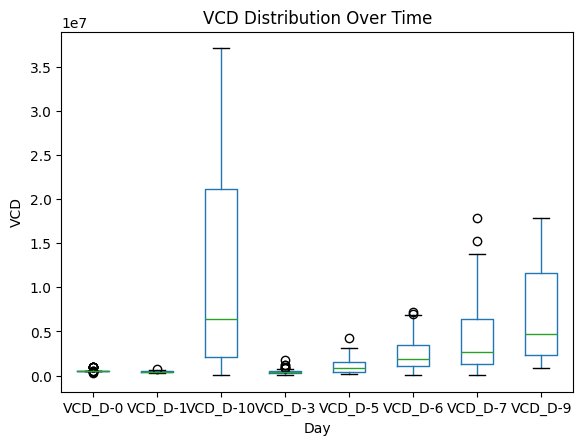

In [45]:
plt.figure(figsize=(10, 6))
df_vcd_long.boxplot(by="Day", column="VCD", grid=False)
plt.title("VCD Distribution Over Time")
plt.suptitle("")  # Remove the automatic title
plt.xlabel("Day")
plt.ylabel("VCD")
plt.show()